#### This module will house the functions and code where we run models and try to get the highest R^squared/lowest RMSLE

In [53]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.reset_defaults()

In [54]:
#Import Data
final_df= pd.read_json('output/final_imputed1.json')
final_df = final_df.sort_values(['join_key', 'year'])

In [55]:
# Adding Lag murer_mans
final_df['lag_y'] = final_df.groupby(['join_key'])['mur_mans'].shift(1)
final_df = final_df.loc[final_df.year >= 2007, :]

In [56]:
# Don't need these variables for modeling - strings and murder derivatives
no_model_vars = ['violent_crime', 'rate_mur_mans', 'rate_violent_crime', 'city_violent_crime',
                  'city_mur_mans','mur_mans','state_key','join_key','MSA','largest_city','city_key']

In [57]:
# Test Set will be 2015 and 2016
final_two = final_df['year'].isin([2015, 2016])
# Need year for indexing but don't put into model
x_vars = final_df.columns.difference(no_model_vars)
model_vars = [x for x in x_vars if x != 'year']

y_var = 'mur_mans'
xtrain = final_df.loc[~final_two, x_vars]
ytrain = final_df.loc[~final_two, y_var]

xtest = final_df.loc[final_two, x_vars]
ytest = final_df.loc[final_two, y_var]

# Store the One Hot Encoded Variables
one_hot_encode_vars = [x for x in x_vars if "MSA_" in x or "year_" in x or "state_" in x or x == 'year']
non_encode_vars = xtrain.columns.difference(one_hot_encode_vars)

# Standardize Continous Variables
cont_vars = xtrain.loc[:, non_encode_vars]
u = cont_vars.mean()
sigma  = cont_vars.std()
std = lambda x: (x - u) / sigma
xtrain.loc[:, non_encode_vars] = std(cont_vars)
xtest.loc[:, non_encode_vars] = std(xtest.loc[:, non_encode_vars])

We will use a simple modified Nearest Neighbors Approach as a baseline. We will write a function 
that calculates the mse coming from predicting using the kth nearest neighbors in the training set. Since our test data is 2015 and 2016. The kth nearest neighbor prediction will be taking the average of the kth years for each MSA before 2015

In [58]:
'''
Function
--------
params_vs_errors

This function will take a list of parameters and a list of
avg mse generated by those params and will plot them

Parameters:
    param_list - list of parameters
    avg_val_errors - list of avg mse (one for each mse)
    param_label - String Label for param
'''
def params_vs_avg_mse(param_list, avg_val_errors, param_label, title):
    plt.plot(avg_val_errors)
    plt.xlabel(param_label)
    plt.ylabel("MSE")
    plt.title(title)
    plt.xticks(np.arange(len(param_list)), param_list)
    plt.show()

In [59]:
'''
Function
-------------
time_series_knn_mse

This function calculates mse from a modified kNN where the nearest neighbors are defined
to be the MSA earlier Years(2014 and before). So if k = 1 we would predict 2014 for 2015 and 2016

Parameters:
k (int) - # of parameters
df - dataframe
'''
def time_series_knn_mse(k, df):
    last_two = df['year'].isin([2015, 2016])
    test = df.loc[last_two, :]
    # Get right number of years based on k
    train_min_year = 2015 - k
    pred_years = df.loc[df.year >= train_min_year, :]
    # Take Mean of Murder by MSA for k neighbors
    pred = pd.DataFrame(pred_years.groupby('join_key')['mur_mans'].mean()).reset_index()
    pred = pred.rename(index=str, columns={'mur_mans': 'pred'}) 
    # Merge to Test and Take MSE
    y_yhat = test.merge(pred, on=['join_key'], indicator=True)
    return(mean_squared_error(y_yhat['mur_mans'], y_yhat['pred']))

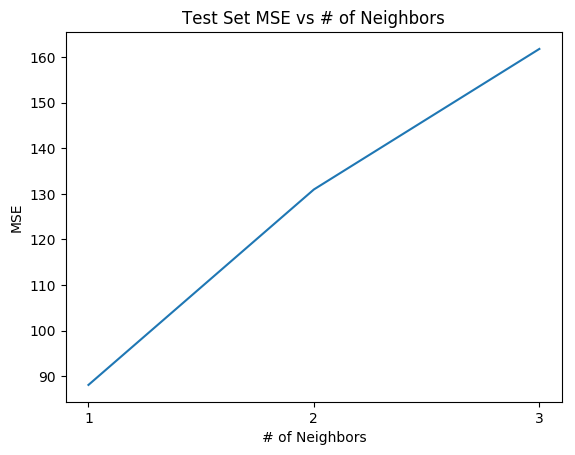

In [60]:
# Find out which k is best for time series kNN
k_errors = []
for i in range(1, 4):
    k_errors.append(time_series_knn_mse(i, final_df))

params_vs_avg_mse(range(1,4), 
                  k_errors, '# of Neighbors',
                 'Test Set MSE vs # of Neighbors')

In [61]:
'''
Function
----------
hyper_tuning

This function will control which parameters we tune for each one
of our regressor model. It takes in a string for model type and parameter
and returns a model with that parameter set.

Parameters

model_type (str)  - "LASSO", "RIDGE", "RF", "GB"
param (float) - number for hyper parameter
'''
def hyper_tuning(model_type, param):
    if model_type == "LASSO":
        m = Lasso(alpha=param)
    elif model_type == "RIDGE":
        m = Ridge(alpha=param)
    elif model_type == "RF":
        m = RandomForestRegressor(n_estimators=param)
    elif model_type == "GB":
        m = GradientBoostingRegressor(n_estimators=param)
    else:
        print("Model type incorrectly specified")
    return(m)

'''
Function
-------------
rolling_window_evaluation

This function takes in a model type, and a training set and performs rolling window cross-validation window
It also takes in a starting size for the rolling window

Parameters:
model_type - "LASSO", "RIDGE", "RF", "GB"
param_list - list of floats
xtrain - features
ytrain - response
min_year - first year of training set
train_set - df
start_window_set

Returns parameter that gave lowest mean squared error
'''
def rolling_window_evaluation(model_type, param_list, xtrain, ytrain, min_year):

    errors = []
    for p in param_list:
        m = hyper_tuning(model_type, p)
        # Capture average cross validation error for this parameter
        p_errors = []
        for yr in range(min_year, 2014):
            # Get indexes for training and testing set
            train_index = xtrain.year <= yr
            
            xtr = xtrain.loc[train_index, model_vars]
            ytr = ytrain[train_index]
            
            xval = xtrain.loc[~train_index, model_vars]
            yval = ytrain[~train_index]
            
            m.fit(xtr, ytr)
            num_years_in_val = 2014 - yr + 1
            # We are going to return error divided by number of years in Val window
            # This will put more weight when validation is later and fewer years
            p_errors.append(mean_squared_error(yval, m.predict(xval)) / num_years_in_val)
        # For this parameter store the average error
        errors.append(np.mean(np.mean(p_errors)))
    # Next I need return the best parameter
    return(param_list[np.argmax(errors)])   

'''
Function
-------------
rolling_window_evaluation

This function takes in a model type, and a training set and performs rolling window cross-validation window
It also takes in a starting size for the rolling window

This is a rolling window such taht validation window is 2010-2014, 2011-2014, etcc

Parameters:
model_type - "LASSO", "RIDGE", "RF", "GB"
param_list - list of floats
xtrain - features
ytrain - response
min_year - first year of training set
train_set - df
start_window_set

Returns parameter that gave lowest mean squared error
'''
def rolling_later(model_type, param_list, xtrain, ytrain, min_year):

    errors = []
    for p in param_list:
        m = hyper_tuning(model_type, p)
        # Capture average cross validation error for this parameter
        p_errors = []
        min_year = xtrain['year'].min()
        if min_year >= 2010:
            start_val = min_year + 1
        else:
            start_val = 2010
        
        for yr in range(start_val, 2015):
            val_index = xtrain.year >= yr
            
            xtr = xtrain.loc[~val_index, model_vars]
            ytr = ytrain[~val_index]
            
            xval = xtrain.loc[val_index, model_vars]
            yval = ytrain[val_index]
            
            m.fit(xtr, ytr)
            num_years_in_val = 2014 - yr + 1
            # We are going to return error divided by number of years in Val window
            # This will put more weight when validation is later and fewer years
            p_errors.append(mean_squared_error(yval, m.predict(xval)) / num_years_in_val)
        # For this parameter store the average error
        errors.append(np.mean(np.mean(p_errors)))
    # Next I need return the best parameter
    return(param_list[np.argmax(errors)])   

In [62]:
# Quick Function to get mse
mse = lambda m: mean_squared_error(ytest, m.predict(xtest.loc[:, model_vars]))

We are now testing whether dropping earlier years in the test set gives better performance. We will first find optimal performance using rolling window cross validation. Then we iterate through min years to see if we get a better test set performance if we train on more recent data

In [ ]:
# This function is going to final optimal parameter for each
# one of our regression model and store it. It will do
# this 6 times each each time we drop all variables <= y
# in below loop
# we are going to try to see if we get performance only
# using more recent data
param_vectors = {"LASSO": [1** x for x in range(-3, 3)], 
                 'RIDGE': [1** x for x in range(-3, 3)], 
                 'RF': [200, 250, 300], 
                 'GB': [200, 250, 300]}
test_errors = {"LASSO":[] , 'RIDGE': [] , 'RF': [], 'GB': []}
for min_year in range(2007, 2013):
    print("Dropping %i" %(min_year - 1))
    # Keep min_year and above
    # first iteration 2006-
    # secon iteration 2007-
    drop_y = final_df.year >= min_year
    xtrain_drop = final_df.loc[(~final_two) & (drop_y), x_vars]
    ytrain_drop = final_df.loc[(~final_two) & (drop_y), y_var]
    # Now Cross Validate on this year range using Rolling Window
    # to final optimal paramter from dictionary above
    for model in param_vectors.keys():
        print(model)
        best_param = rolling_later(model, 
                                   param_vectors[model],
                                   xtrain_drop,
                                   ytrain_drop,
                                   min_year)
        #best_param = rolling_window_evaluation(model, 
        #                                      param_vectors[model],
        #                                      xtrain_drop,
        #                                      ytrain_drop,
        #                                      min_year)
        print(best_param)
        if model == "LASSO":
            best_m = Lasso(alpha=best_param)
        elif model == "RIDGE":
            best_m = Ridge(alpha=best_param)
        elif model == "RF":
            best_m = RandomForestRegressor(n_estimators=best_param)
        elif model == "GB":
            best_m = GradientBoostingRegressor(n_estimators=best_param)
        
        # Now fit on training set with certain years dropped and predict on the test
        best_m.fit(xtrain_drop.loc[:, model_vars], ytrain_drop)
        test_errors[model].append(mse(best_m))

Dropping 2006
LASSO
1.0
RIDGE
1.0
RF
250
GB
250
Dropping 2007
LASSO
1.0
RIDGE
1.0
RF


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
for k in test_errors.keys():
    ax.plot(test_errors[k], label=k)
    ax.set_xlabel("First Year of Training Data")
    ax.set_ylabel("MSE")
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels( ['2007', '2008', '2009', '2010', '2011', '2012'])
    ax.set_title("First year of Trai data vs Test SEt Performance")
    ax.legend(loc='best')
plt.show()